In [ ]:
import sys
from os.path import join
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
!rm -rf ./logs/
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import ResNet50
import os
import datetime
from sklearn.model_selection import KFold
from tensorflow import keras
import pandas as pd
from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Model
from keras import datasets



%load_ext tensorboard
from google.colab import drive
drive.mount('/content/drive')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.kaggle.com/code/drscarlat/melanoma-resnet50-fine-tune/notebook

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(x_train, Y_train), (x_test, Y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
Y_train, Y_test = Y_train.flatten(), Y_test.flatten()

X_train, Y_train = shuffle(x_train, Y_train, random_state=14)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
del X_train, Y_train
print("shape of X_train", x_train.shape)
print("shape of y_train", y_train.shape)
print("shape of X_test", x_val.shape)
print("shape of y_test", y_val.shape)

shape of X_train (40000, 32, 32, 3)
shape of y_train (40000,)
shape of X_test (10000, 32, 32, 3)
shape of y_test (10000,)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, Y_test))

train_dataset = train_dataset.shuffle(40000).batch(128)
val_dataset = val_dataset.batch(128)
del x_train, y_train, x_val, y_val

https://www.kaggle.com/code/drscarlat/melanoma-resnet50-fine-tune/notebook

In [ ]:
base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

print(base.summary())

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
teacher = models.Sequential()
teacher.add(layers.Lambda(lambda x: tf.image.resize(x,(224, 224))))
teacher.add(base)
teacher.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
teacher.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Make the conv_base NOT trainable:

for layer in base.layers[:]:
   layer.trainable = False

print('conv_base is now NOT trainable')

conv_base is now NOT trainable


In [ ]:
for i, layer in enumerate(base.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
teacher.compile(optimizer=optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("model compiled")

model compiled


In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
teacher.fit(x=train_dataset, epochs=10, validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/10
313/313 [==============================] - 194s 580ms/step - loss: 3.3577 - accuracy: 0.7853 - val_loss: 3.4764 - val_accuracy: 0.7962
Epoch 2/10
313/313 [==============================] - 176s 564ms/step - loss: 1.1521 - accuracy: 0.9128 - val_loss: 3.0812 - val_accuracy: 0.8421
Epoch 3/10
313/313 [==============================] - 176s 563ms/step - loss: 0.6021 - accuracy: 0.9496 - val_loss: 3.3135 - val_accuracy: 0.8423
Epoch 4/10
313/313 [==============================] - 176s 564ms/step - loss: 0.4226 - accuracy: 0.9630 - val_loss: 4.1682 - val_accuracy: 0.8425
Epoch 5/10
313/313 [==============================] - 177s 565ms/step - loss: 0.3738 - accuracy: 0.9692 - val_loss: 3.7051 - val_accuracy: 0.8569
Epoch 6/10
313/313 [==============================] - 176s 564ms/step - loss: 0.3315 - accuracy: 0.9728 - val_loss: 4.8173 - val_accuracy: 0.8415
Epoch 7/10
313/313 [==============================] - 176s 562ms/step - loss: 0.3193 - accuracy: 0.9750 - val_loss: 5.9384 -

In [ ]:
print(teacher.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 10)                1003530   
                                                                 
Total params: 24,591,242
Trainable params: 1,003,530
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
ModelLoss, ModelAccuracy = teacher.evaluate(x_test, Y_test)
print('Model Accuracy is {}'.format(ModelAccuracy))
print('Model Loss is {}'.format(ModelLoss))

313/313 [==============================] - 42s 107ms/step - loss: 5.9539 - accuracy: 0.8570
Model Accuracy is 0.8569999933242798
Model Loss is 5.95386266708374


teacher evaluation:

test accuracy: %85.7

train accuracy: %98.02

val accuracy: %85.59

In [ ]:
teacher.save('/content/drive/MyDrive/Colab_Notebook/Deep_Learning/hw3/teacher')

Archive:  /content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw3/teacher.zip
  inflating: teacher/keras_metadata.pb  
  inflating: teacher/saved_model.pb  
   creating: teacher/assets/
  inflating: teacher/variables/variables.index  
  inflating: teacher/variables/variables.data-00000-of-00001  


https://keras.io/examples/vision/knowledge_distillation/

https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras/notebook

https://github.com/songrise/CNN_Keras/blob/main/src/ResNet-18.py

In [ ]:
class ResnetBlock(Model):

    def __init__(self, channels: int, down_sample=False):

        super().__init__()
        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]
        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"
        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0], kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1], kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()
        if self.__down_sample:
            self.res_conv = Conv2D(self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()
    def call(self, inputs):
        res = inputs
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [ ]:
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):

        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):

        x, y = data

        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:

            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)


            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)
        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
!unzip "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw3/teacher.zip"

Archive:  /content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw3/teacher.zip
  inflating: teacher/keras_metadata.pb  
  inflating: teacher/saved_model.pb  
   creating: teacher/assets/
  inflating: teacher/variables/variables.index  
  inflating: teacher/variables/variables.data-00000-of-00001  


In [ ]:
teacher = tf.keras.models.load_model('/content/teacher')

student_base = ResNet18(10)
student_base.build(input_shape = (None,224, 224, 3))
student = models.Sequential()
student.add(layers.Lambda(lambda x: tf.image.resize(x,(224, 224))))
student.add(student_base)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_train = X_train.astype("float32")
X_train = np.reshape(X_train, (-1, 32, 32, 3))
X_test = X_test.astype("float32")
X_test = np.reshape(X_test, (-1, 32, 32, 3))

**Cross Validation result for alpha and temperature** : epoch = 2

alpha = [0.3, 0.5, 0.7, 0.8]

temperature = [10, 13, 16, 18]


In [ ]:
n_split = 16
iii = 0
jjj = 0
alpha = [0.3, 0.5, 0.7, 0.8]
temperature = [10, 13, 16, 18]
for train_index, test_index in KFold(n_split).split(Y_train):
  x_train, x_test=X_train[train_index], X_train[test_index]
  y_train,y_test=Y_train[train_index], Y_train[test_index]

  distiller = Distiller(student=student, teacher=teacher)
  distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=alpha[iii],
    temperature=temperature[jjj])

  print(alpha[iii], temperature[jjj])

  distiller.fit(x_train, y_train, epochs=2)
  if iii % 3 == 0 and iii!=0:
    iii = -1
    jjj += 1
  iii += 1

  ModelAccuracy, ModelLoss = distiller.evaluate(x_test, y_test)
  print('\nModel Loss is {}'.format(ModelLoss))
  print('Model Accuracy is {}'.format(ModelAccuracy))

0.3 10
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1465/1465 [==============================] - 314s 205ms/step - sparse_categorical_accuracy: 0.5311 - student_loss: 1.3105 - distillation_loss: 0.0312
Epoch 2/2
98/98 [==============================] - 4s 40ms/step - sparse_categorical_accuracy: 0.6938 - student_loss: 0.8823

Model Loss is 0.8487570881843567
Model Accuracy is 0.6937599778175354
0.5 10
Epoch 1/2
1465/1465 [==============================] - 315s 213ms/step - sparse_categorical_accuracy: 0.7760 - student_loss: 0.6418 - distillation_loss: 0.0167
Epoch 2/2
98/98 [==============================] - 4s 37ms/step - sparse_categorical_accuracy: 0.7677 - student_loss: 0.6988

Model Loss is 0.7113745808601379
Model Accuracy is 0.7676799893379211
0.7 10
Epoch 1/2
1465/1465 [==============================] - 311s 210ms/step - sparse_categorical_accuracy: 0.8565 - student_loss: 0.4138 - distillation_loss: 0.0119
Epoch 2/2
98/98 [==============================] - 4s 38ms/step - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4682

**Cross Validation result for alpha and temperature** : epoch = 2

alpha = [0.3, 0.5, 0.7, 0.8]

temperature = [10, 13, 16, 18]

=============================================

alpha, temperature = 0.3, 10

      Model Loss is 0.8487570881843567
      Model Accuracy is 0.6937599778175354

alpha, temperature = 0.5, 10

      Model Loss is 0.7113745808601379
      Model Accuracy is 0.7676799893379211

alpha, temperature = 0.7, 10

      Model Loss is 0.45404067635536194
      Model Accuracy is 0.8399999737739563

alpha, temperature = 0.8, 10

      Model Loss is 0.13248617947101593
      Model Accuracy is 0.8393599987030029

alpha, temperature = 0.3, 13

      Model Loss is 0.22280919551849365

      Model Accuracy is 0.9097599983215332

alpha, temperature = 0.5, 13

      Model Loss is 0.13048599660396576
      Model Accuracy is 0.9376000165939331

alpha, temperature = 0.7, 13

      Model Loss is 0.03905726224184036
      Model Accuracy is 0.9542400240898132

alpha, temperature = 0.8, 13

      Model Loss is 0.011057557538151741
      Model Accuracy is 0.955839991569519

alpha, temperature = 0.3, 16

      Model Loss is 0.11320044845342636
      Model Accuracy is 0.9651200175285339

alpha, temperature = 0.5, 16

      Model Loss is 0.048935361206531525
      Model Accuracy is 0.9849600195884705

alpha, temperature = 0.7, 16

      Model Loss is 0.1511480212211609
      Model Accuracy is 0.9599999785423279

alpha, temperature = 0.8, 16
      
      Model Loss is 0.19836834073066711
      Model Accuracy is 0.9391999840736389

alpha, temperature = 0.3, 18

      Model Loss is 0.03684317693114281
      Model Accuracy is 0.9609599709510803

alpha, temperature = 0.5, 18

      Model Loss is 0.018668007105588913
      Model Accuracy is 0.9641600251197815

alpha, temperature = 0.7, 18

      Model Loss is 0.0032949671149253845
      Model Accuracy is 0.9884799718856812

alpha, temperature = 0.8, 18
      
      Model Loss is 0.07706267386674881
      Model Accuracy is 0.9900799989700317

Cross Validation:

alpha = [0.1, 0.3, 0.5, 0.7]

temperature = [7, 10, 13, 16]

In [ ]:
n_split = 16
iii = 0
jjj = 0
alpha = [0.1, 0.3, 0.5, 0.7]
temperature = [7, 10, 13, 16]
for train_index, test_index in KFold(n_split).split(Y_train):
  x_train, x_test=X_train[train_index], X_train[test_index]
  y_train,y_test=Y_train[train_index], Y_train[test_index]

  distiller = Distiller(student=student, teacher=teacher)
  distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=alpha[iii],
    temperature=temperature[jjj])

  print(alpha[iii], temperature[jjj])

  distiller.fit(x_train, y_train, epochs=2)
  if iii % 3 == 0 and iii!=0:
    iii = -1
    jjj += 1
  iii += 1

  ModelAccuracy, ModelLoss = distiller.evaluate(x_test, y_test)
  print('\nModel Loss is {}'.format(ModelLoss))
  print('Model Accuracy is {}'.format(ModelAccuracy))

0.1 7
Epoch 1/2
1465/1465 [==============================] - 307s 207ms/step - sparse_categorical_accuracy: 0.5025 - student_loss: 1.3919 - distillation_loss: 0.0334
Epoch 2/2
98/98 [==============================] - 4s 36ms/step - sparse_categorical_accuracy: 0.7174 - student_loss: 0.7895

Model Loss is 0.6231356859207153
Model Accuracy is 0.7174400091171265
0.3 7
Epoch 1/2
1465/1465 [==============================] - 309s 207ms/step - sparse_categorical_accuracy: 0.7682 - student_loss: 0.6689 - distillation_loss: 0.0176
Epoch 2/2
98/98 [==============================] - 4s 36ms/step - sparse_categorical_accuracy: 0.7491 - student_loss: 0.7461

Model Loss is 0.6829172968864441
Model Accuracy is 0.7491199970245361
0.5 7
Epoch 1/2
1465/1465 [==============================] - 307s 207ms/step - sparse_categorical_accuracy: 0.8538 - student_loss: 0.4220 - distillation_loss: 0.0122
Epoch 2/2
98/98 [==============================] - 4s 36ms/step - sparse_categorical_accuracy: 0.8224 - studen

In [ ]:
n_split = 16
iii = 0
jjj = 0
alpha = [0.1, 0.3, 0.5, 0.7]
temperature = [7, 10, 13, 16]
for train_index, test_index in KFold(n_split).split(Y_train):
  print(alpha[iii], temperature[jjj])
  if temperature[jjj] in [7, 10]:
    print("pass")
    if iii % 3 == 0 and iii!=0:
      iii = -1
      jjj += 1
    iii += 1
  else:
    x_train, x_test=X_train[train_index], X_train[test_index]
    y_train,y_test=Y_train[train_index], Y_train[test_index]

    distiller = Distiller(student=student, teacher=teacher)
    distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=alpha[iii],
    temperature=temperature[jjj])
    distiller.fit(x_train, y_train, epochs=2)
    ModelAccuracy, ModelLoss = distiller.evaluate(x_test, y_test)
    print('\nModel Loss is {}'.format(ModelLoss))
    print('Model Accuracy is {}'.format(ModelAccuracy))
    if iii % 3 == 0 and iii!=0:
      iii = -1
      jjj += 1
    iii += 1

0.1 7
pass
0.3 7
pass
0.5 7
pass
0.7 7
pass
0.1 10
pass
0.3 10
pass
0.5 10
pass
0.7 10
pass
0.1 13
Epoch 1/2


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1465/1465 [==============================] - 307s 200ms/step - sparse_categorical_accuracy: 0.5064 - student_loss: 1.3741 - distillation_loss: 0.0321
Epoch 2/2
98/98 [==============================] - 4s 37ms/step - sparse_categorical_accuracy: 0.5549 - student_loss: 1.3738

Model Loss is 0.6897273659706116
Model Accuracy is 0.5548800230026245
0.3 13
Epoch 1/2
1465/1465 [==============================] - 302s 204ms/step - sparse_categorical_accuracy: 0.7700 - student_loss: 0.6661 - distillation_loss: 0.0170
Epoch 2/2
98/98 [==============================] - 4s 34ms/step - sparse_categorical_accuracy: 0.8058 - student_loss: 0.5568

Model Loss is 0.30154141783714294
Model Accuracy is 0.8057600259780884
0.5 13
Epoch 1/2
1465/1465 [==============================] - 301s 203ms/step - sparse_categorical_accuracy: 0.8507 - student_loss: 0.4297 - distillation_loss: 0.0120
Epoch 2/2
98/98 [==============================] - 4s 34ms/step - sparse_categorical_accuracy: 0.8138 - student_loss: 0.536

**Cross Validation result for alpha and temperature** : epoch = 2

alpha, temperature = 0.1, 7

        Model Loss is 0.6231356859207153

        Model Accuracy is 0.7174400091171265

alpha, temperature = 0.3, 7

        Model Loss is 0.6829172968864441
  
        Model Accuracy is 0.7491199970245361

alpha, temperature = 0.5, 7

        Model Loss is 0.4101206064224243
  
        Model Accuracy is 0.8223999738693237

alpha, temperature = 0.7, 7

        Model Loss is 0.18450286984443665
      
        Model Accuracy is 0.9088000059127808

alpha, temperature = 0.1, 10

        Model Loss is 0.1238110288977623
      
        Model Accuracy is 0.9404799938201904

alpha, temperature = 0.3, 10

        Model Loss is 0.027051378041505814
      
        Model Accuracy is 0.9283199906349182

alpha, temperature = 0.5, 10

        Model Loss is 0.0952586755156517
      
        Model Accuracy is 0.955839991569519

alpha, temperature = 0.7, 10

        Model Accuracy is 0.9136000275611877
        
        Model Loss is 0.3140583336353302

alpha, temperature = 0.1, 13

        Model Loss is 0.6897273659706116
  
        Model Accuracy is 0.5548800230026245

alpha, temperature = 0.3, 13

        Model Loss is 0.30154141783714294
        Model Accuracy is 0.8057600259780884

alpha, temperature = 0.5, 13

        Model Loss is 0.3543245494365692
      
        Model Accuracy is 0.813759982585907

alpha, temperature = 0.7, 13

        Model Loss is 0.22532203793525696
        
        Model Accuracy is 0.8755199909210205

alpha, temperature = 0.1, 16

        Model Loss is 0.19593480229377747
        
        Model Accuracy is 0.9196799993515015

alpha, temperature = 0.3, 16

        Model Loss is 0.12011982500553131
      
        Model Accuracy is 0.9510400295257568

alpha, temperature = 0.5, 16

        Model Loss is 0.04457022622227669
      
        Model Accuracy is 0.9667199850082397

alpha, temperature = 0.7, 16

        Model Loss is 0.01704961620271206
        
        Model Accuracy is 0.9750400185585022

====================================================

best parameter:

alpha = 0.8

temperature = 18


Loss : 0.07706267386674881

Accuracy : 0.9900799989700317

====================================================

Training : alpha = 0.8 ,temperature = 18

In [ ]:
# Distill teacher to student

# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.8,
    temperature=18,
)

In [ ]:
# Distill teacher to student
distiller.fit(X_train, Y_train, epochs=11)

# Evaluate student on test dataset
distiller.evaluate(X_test, Y_test)

Epoch 1/11


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 328s 202ms/step - sparse_categorical_accuracy: 0.5028 - student_loss: 1.3780 - distillation_loss: 0.0318
Epoch 2/11
1563/1563 [==============================] - 313s 200ms/step - sparse_categorical_accuracy: 0.7087 - student_loss: 0.8259 - distillation_loss: 0.0205
Epoch 3/11
1563/1563 [==============================] - 313s 200ms/step - sparse_categorical_accuracy: 0.7827 - student_loss: 0.6249 - distillation_loss: 0.0160
Epoch 4/11
1563/1563 [==============================] - 313s 200ms/step - sparse_categorical_accuracy: 0.8271 - student_loss: 0.4962 - distillation_loss: 0.0133
Epoch 5/11
1563/1563 [==============================] - 313s 201ms/step - sparse_categorical_accuracy: 0.8590 - student_loss: 0.4048 - distillation_loss: 0.0114
Epoch 6/11
1563/1563 [==============================] - 314s 201ms/step - sparse_categorical_accuracy: 0.8898 - student_loss: 0.3137 - distillation_loss: 0.0098
Epoch 7/11
1563/1563 [=======================

[0.8395000100135803, 0.8694968819618225]

alpha = 0.8

temperature = 18

test accuracy:

      0.8395000100135803

test loss:

      0.8694968819618225

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# Normalize the data.
x_train = x_train.astype('float32')
X_test = x_test.astype('float32')
x_train /= 255.0
X_test /= 255.0

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2,shuffle = True)
print("X_train: ", X_train.shape)
print("Y_train: ", y_train.shape)
print("\nX_test: ", X_test.shape)
print("Y_test: ", y_test.shape)
print("\nX_val: ", X_val.shape)
print("Y_val: ", y_val.shape)

X_train:  (40000, 32, 32, 3)
Y_train:  (40000, 1)

X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)

X_val:  (10000, 32, 32, 3)
Y_val:  (10000, 1)


In [ ]:
encoder = OneHotEncoder()
encoder.fit(y_train)
Y_train = encoder.transform(y_train).toarray()
Y_test = encoder.transform(y_test).toarray()
Y_val =  encoder.transform(y_val).toarray()

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

train_dataset = train_dataset.shuffle(60000).batch(128)
val_dataset = val_dataset.batch(128)
# del X_train, Y_train, X_val, Y_val, X_test, Y_test, x_train, y_train, x_test, y_test

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator
# aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
#                              height_shift_range=0.05)
# aug.fit(X_train)

In [ ]:
student_base = ResNet18(10)
student_base.build(input_shape = (None,224, 224, 3))
student = models.Sequential()
student.add(layers.Lambda(lambda x: tf.image.resize(x,(224, 224))))
student.add(student_base)
student.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"])

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, mode='auto',min_delta=0.002, restore_best_weights=True)

history = student.fit(x=train_dataset,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback])

Epoch 1/100
313/313 [==============================] - 146s 423ms/step - loss: 1.4045 - accuracy: 0.5008 - val_loss: 1.9576 - val_accuracy: 0.3978
Epoch 2/100
313/313 [==============================] - 131s 418ms/step - loss: 0.8662 - accuracy: 0.6938 - val_loss: 1.5954 - val_accuracy: 0.4783
Epoch 3/100
313/313 [==============================] - 131s 417ms/step - loss: 0.6450 - accuracy: 0.7731 - val_loss: 1.8131 - val_accuracy: 0.5348
Epoch 4/100
313/313 [==============================] - 130s 416ms/step - loss: 0.5109 - accuracy: 0.8209 - val_loss: 2.0435 - val_accuracy: 0.5652
Epoch 5/100
313/313 [==============================] - 131s 418ms/step - loss: 0.4157 - accuracy: 0.8550 - val_loss: 1.4214 - val_accuracy: 0.6509
Epoch 6/100
313/313 [==============================] - 131s 418ms/step - loss: 0.3277 - accuracy: 0.8854 - val_loss: 1.0105 - val_accuracy: 0.7010
Epoch 7/100
313/313 [==============================] - 130s 416ms/step - loss: 0.2529 - accuracy: 0.9102 - val_loss: 2

In [ ]:
ModelLoss, ModelAccuracy = student.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 41s 32ms/step - loss: 0.0422 - accuracy: 0.9854
Model Loss is 0.04221908748149872
Model Accuracy is 0.9854000210762024


In [ ]:
ModelLoss, ModelAccuracy = student.evaluate(X_test, Y_test)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

313/313 [==============================] - 11s 33ms/step - loss: 0.8673 - accuracy: 0.8227
Model Loss is 0.8673175573348999
Model Accuracy is 0.822700023651123


Result:

      train Loss : 0.04221908748149872

      train Accuracy : 0.9854000210762024

      test Loss : 0.8673175573348999

      test Accuracy : 0.822700023651123

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


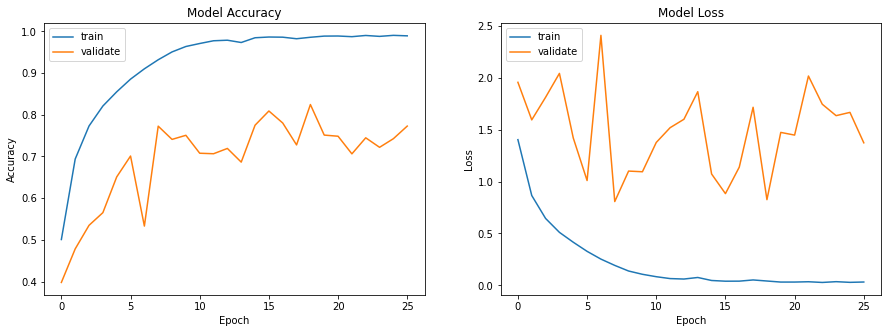

In [ ]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')

    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

with distilation algorithm:

      test accuracy : 0.84

      test loss : 0.87


without distilation algorithm(ResNet18):
    
      test Loss : 0.87

      test Accuracy : 0.823

مطابق توضیحاتی که در وب سایت معرفی شده در دستورکار وجود دارد در حالتی که مدل از صفر بر روی دیتای آموزشی ترین شود به دقت پایین تری میرسیم. در قسمت قبل از الگوریتم گفته شده استفاده شد و به این صورت بود که دو تابع هزینه بین خروجی مدل با لیبل های واقعی و تابع هزینه بین مدل و خروجی های مدل معلم در نظر گرفته شد. این کار باعث شد تا از یادگیری‌ای که پیش از این بر روی مدل معلم صورت گرفته شده بود استفاده شود و به نوعی این اطلاعات به مدل کوچکتر منتقل شود.
به عبارت دیگر در حالتی که ما از لیبل های هارد استفاده کنیم و مدل به دنبال یادگیری آنها باشد پروسه آموزش ضعیف تر از حالتی است که ما با لیبل‌های نرم (که در مدلی با دقت خوب به دست آمده‌اند) عمل میکنیم

In [ ]:
# IMPORT MODULES
import sys
from os.path import join
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
!rm -rf ./logs/
%load_ext tensorboard

from google.colab import drive
drive.mount('/content/drive')

#from tensorflow.python.keras.applications import ResNet50
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import ResNet50
from google.colab import drive
import os

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base = ResNet50(weights = None, include_top=False, input_shape=(224, 224, 3))

print(base.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model = models.Sequential()
model.add(layers.Lambda(lambda x: tf.image.resize(x,(224, 224))))
model.add(base)
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer=optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("model compiled")

model compiled


In [ ]:
### batch = 64

# Load in the data
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

X_train, X_test = X_train / 255.0, X_test / 255.0
# flatten the label values
Y_train, Y_test = Y_train.flatten(), Y_test.flatten()

X_train, Y_train = shuffle(X_train, Y_train, random_state=14)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
# del X_train, Y_train
print("shape of X_train", x_train.shape)
print("shape of y_train", y_train.shape)
print("shape of X_test", x_val.shape)
print("shape of y_test", y_val.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

train_dataset = train_dataset.shuffle(60000).batch(64)
val_dataset = val_dataset.batch(64)
# del x_train, y_train, x_val, y_val, X_test, Y_test

170498071/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
shape of X_train (40000, 32, 32, 3)
shape of y_train (40000,)
shape of X_test (10000, 32, 32, 3)
shape of y_test (10000,)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, mode='auto',min_delta=0.005, restore_best_weights=True)

model.fit(x=train_dataset,
          epochs=50,
          validation_data=val_dataset,
          callbacks=[callback])

Epoch 1/50
625/625 [==============================] - 434s 660ms/step - loss: 3.6616 - accuracy: 0.3381 - val_loss: 1.6491 - val_accuracy: 0.4253
Epoch 2/50
625/625 [==============================] - 412s 660ms/step - loss: 1.5248 - accuracy: 0.4911 - val_loss: 1.3719 - val_accuracy: 0.5349
Epoch 3/50
625/625 [==============================] - 412s 659ms/step - loss: 1.1701 - accuracy: 0.5940 - val_loss: 1.1575 - val_accuracy: 0.5950
Epoch 4/50
625/625 [==============================] - 412s 659ms/step - loss: 0.9816 - accuracy: 0.6610 - val_loss: 1.6783 - val_accuracy: 0.6292
Epoch 5/50
625/625 [==============================] - 412s 660ms/step - loss: 0.8267 - accuracy: 0.7138 - val_loss: 1.1120 - val_accuracy: 0.6679
Epoch 6/50
625/625 [==============================] - 413s 660ms/step - loss: 0.7195 - accuracy: 0.7530 - val_loss: 0.9293 - val_accuracy: 0.7205
Epoch 7/50
625/625 [==============================] - 413s 660ms/step - loss: 0.6117 - accuracy: 0.7959 - val_loss: 0.9180 -

In [ ]:
## Evaluation

ModelLoss, ModelAccuracy = model.evaluate(X_test, Y_test)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

313/313 [==============================] - 30s 95ms/step - loss: 0.8515 - accuracy: 0.7610
Model Loss is 0.8514980673789978
Model Accuracy is 0.7609999775886536


Model Loss : 0.85

Model Accuracy : 0.761

با توجه به اینکه دیتای مورد استفاده دیتای سختی محسوب نمیشود و با توجه به نتایج به دست آمده (دقت 0.76) مشخص است مدل اورفیت شده است. در واقع در صورتی که مدل با تعداد پارامتر بالا مشابه آنچه در این سوال وجود دارد بر روی دیتاستی کوچک ترین شود این اتفاق خواهد افتاد. معمولا گفته میشود به ده برابر تعداد پارامترها داده آموزشی نیاز داریم که در اینجا با وجود اینکه بیش از 23.5 میلیون پارامتر در شبکه وجود دارد تنها 40000 داده‌ی آموزشی داریم. اما در قسمت آ وزن‌هایی که مدل از دیتاستی که پیش از این روی آن ترین شده بود داشت و تنها یک لایه با 10 نرون به آن اضاف شد و این تعداد برای آموزش شبکه کافی بود. در آن حالت دقت حدود %85.7 درصد به دست آمد. اما به نظر میرسد اگر از لایه‌های بیشتری از لایه کاملا متصل نیز استفاده میشد احتمالا به دقت بالاتر از این نیز میرسیدیم